# Adaptive Neuron Thresholding

## Load data from AWS
Data is downloaded via cloud-volume. Here, we select the first segment from the 7th brain segment. The downloaded iamge is of 132x100x52 voxel volume.

In [1]:
import brainlit
from brainlit.utils.session import NeuroglancerSession
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
import napari
from napari.utils import nbscreenshot
%gui qt

/Users/thomasathey/Documents/mimlab/mouselight/env/lib/python3.8/site-packages/python_jsonschema_objects/__init__.py:50: UserWarning: Schema version http://json-schema.org/draft-04/schema not recognized. Some keywords and features may not be supported.
  warnings.warn(
Downloading:   0%|          | 0/1 [00:00<?, ?it/s]


In [ ]:
url = "s3://open-neurodata/brainlit/brain1"
ngl = NeuroglancerSession(url, mip=1)
img, bounds, voxel = ngl.pull_chunk(7, 1)

Let's take a look at the downloaded volume. Napari will open in a new window.

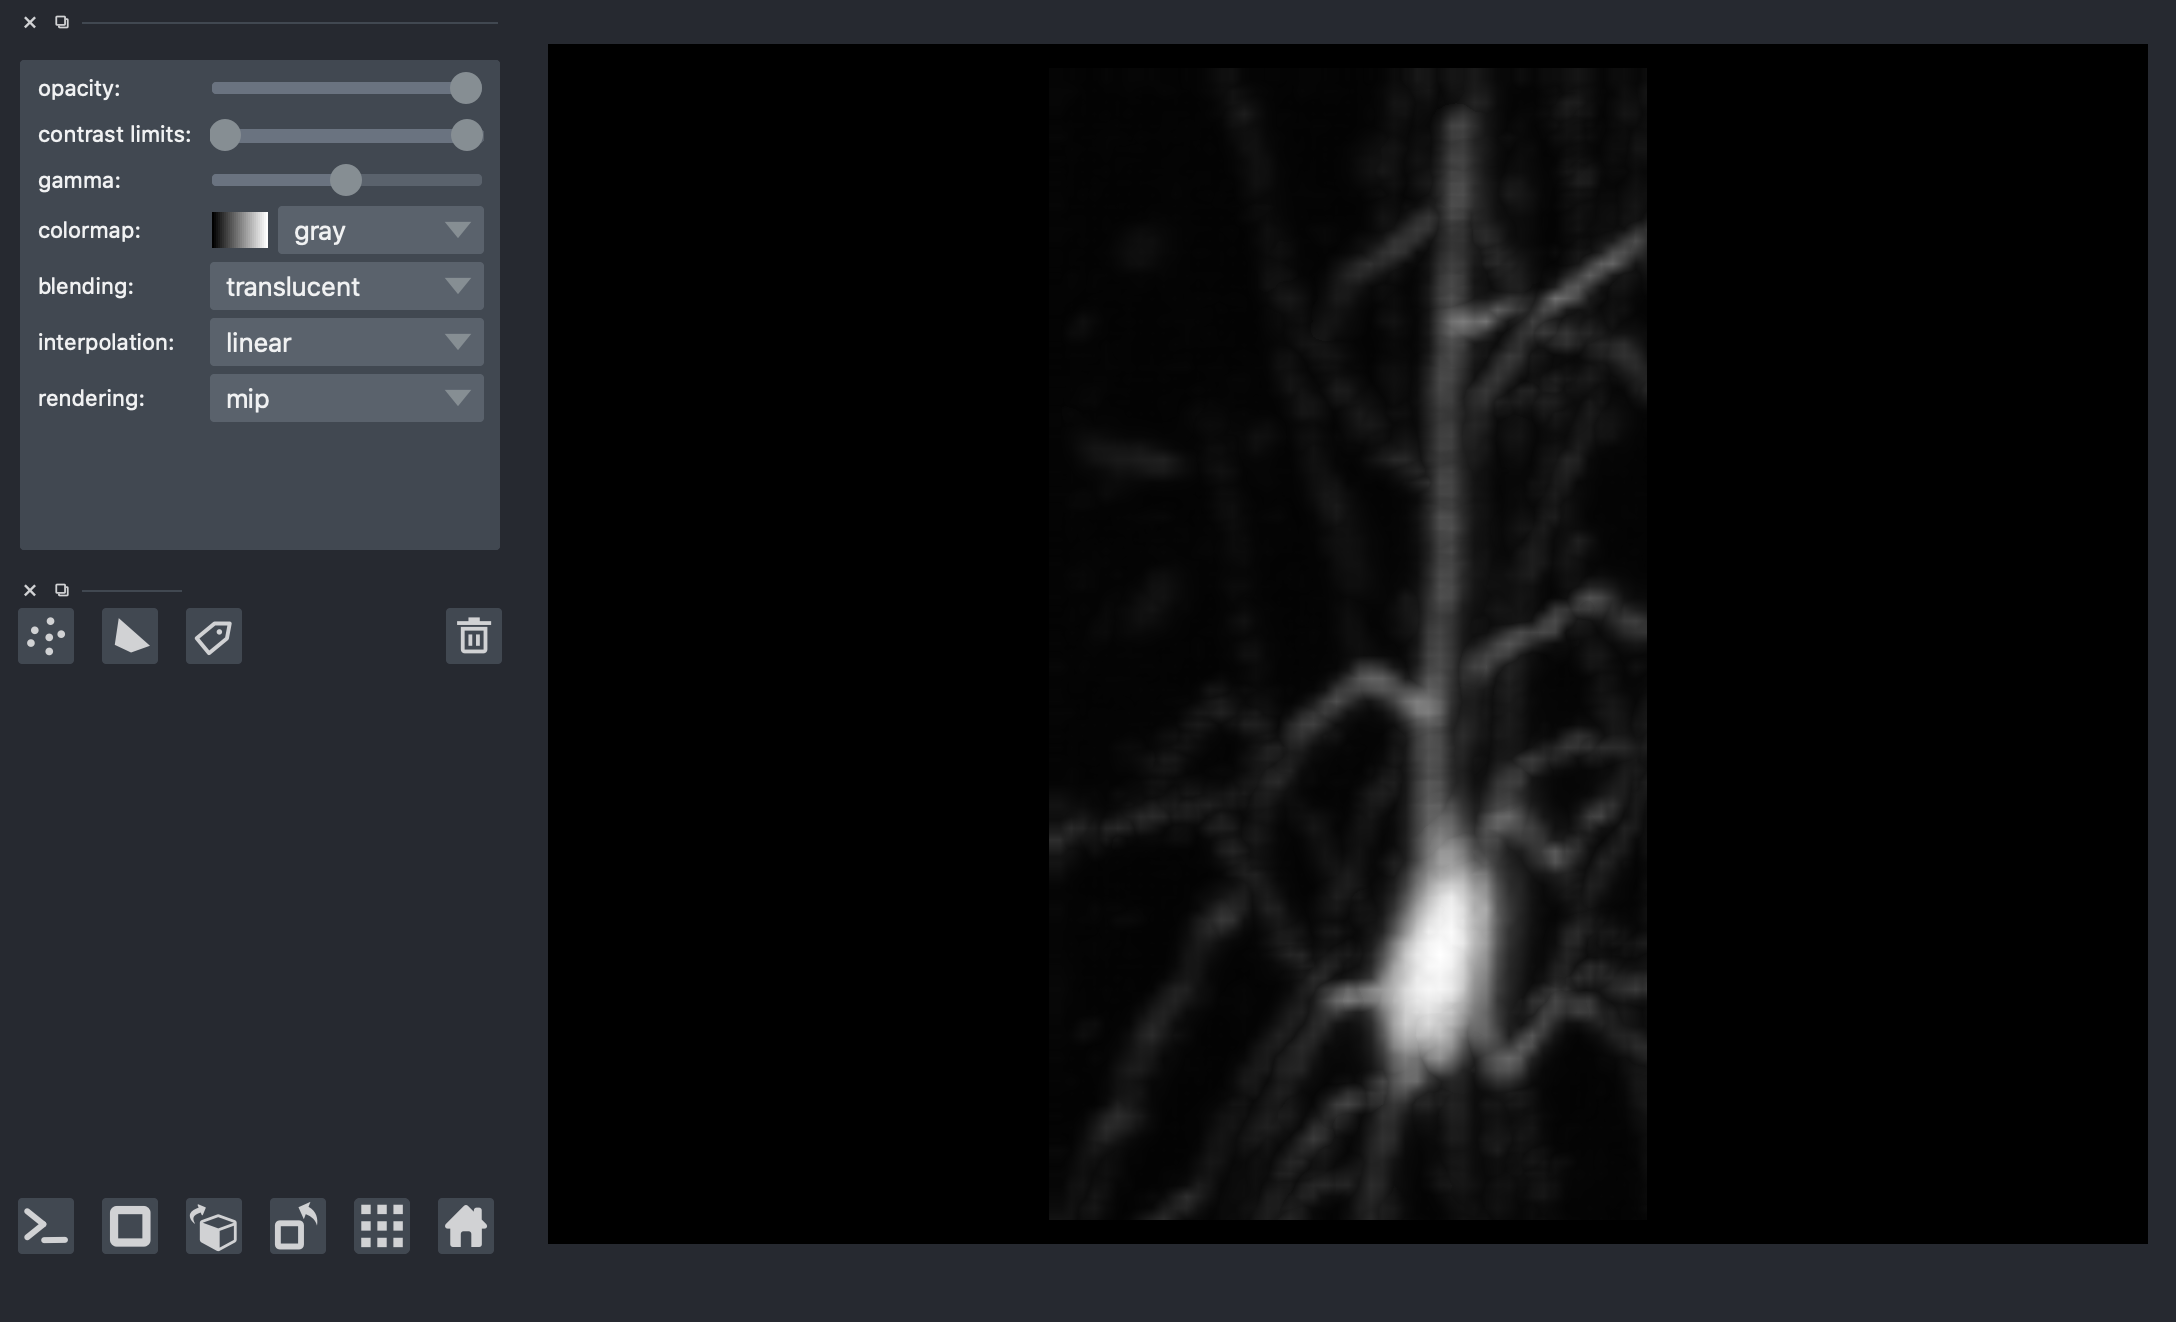

In [13]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(img)
nbscreenshot(viewer)

## Generate Segmentations
Next, we will generate segmentations using the following algorithms: \ Gaussian Mixture Model Thresholding \ Otsu\ Connected Threshold\ Confidence-Connected Threshold\ Neighborhood-Connected Threshold\ Level-Set Segmentation\ Fast-Marching Segmentation

The segmentations from the functions are output as numpy arrays, so segmentation results can easily be displayed locally and are compatible with Neuroglancer.

To start, we'll import adaptive_thresh to access the segmentation algorithms and convert the cloudvolume volume of the brain to a SimpleITK image format for segmentation.

In [14]:
from brainlit.algorithms.generate_fragments import adaptive_thresh
img_T1, img_T1_255 = adaptive_thresh.get_img_T1(img)
seed = (21,76,33)
# numpy and sitk has different order of reading x,y, and z coordinates
numpy_seed, sitk_seed = adaptive_thresh.get_seed(seed)

## Gaussian Mixture Model Thresholding
In this algorithm, a 2-component Gaussian mixture model is trained on the volume. Since neurons have higher voxel intensities in the Mouselight data than the background intensity, we threshold the entire volume by the least intensity in the component containing the highest intensity.

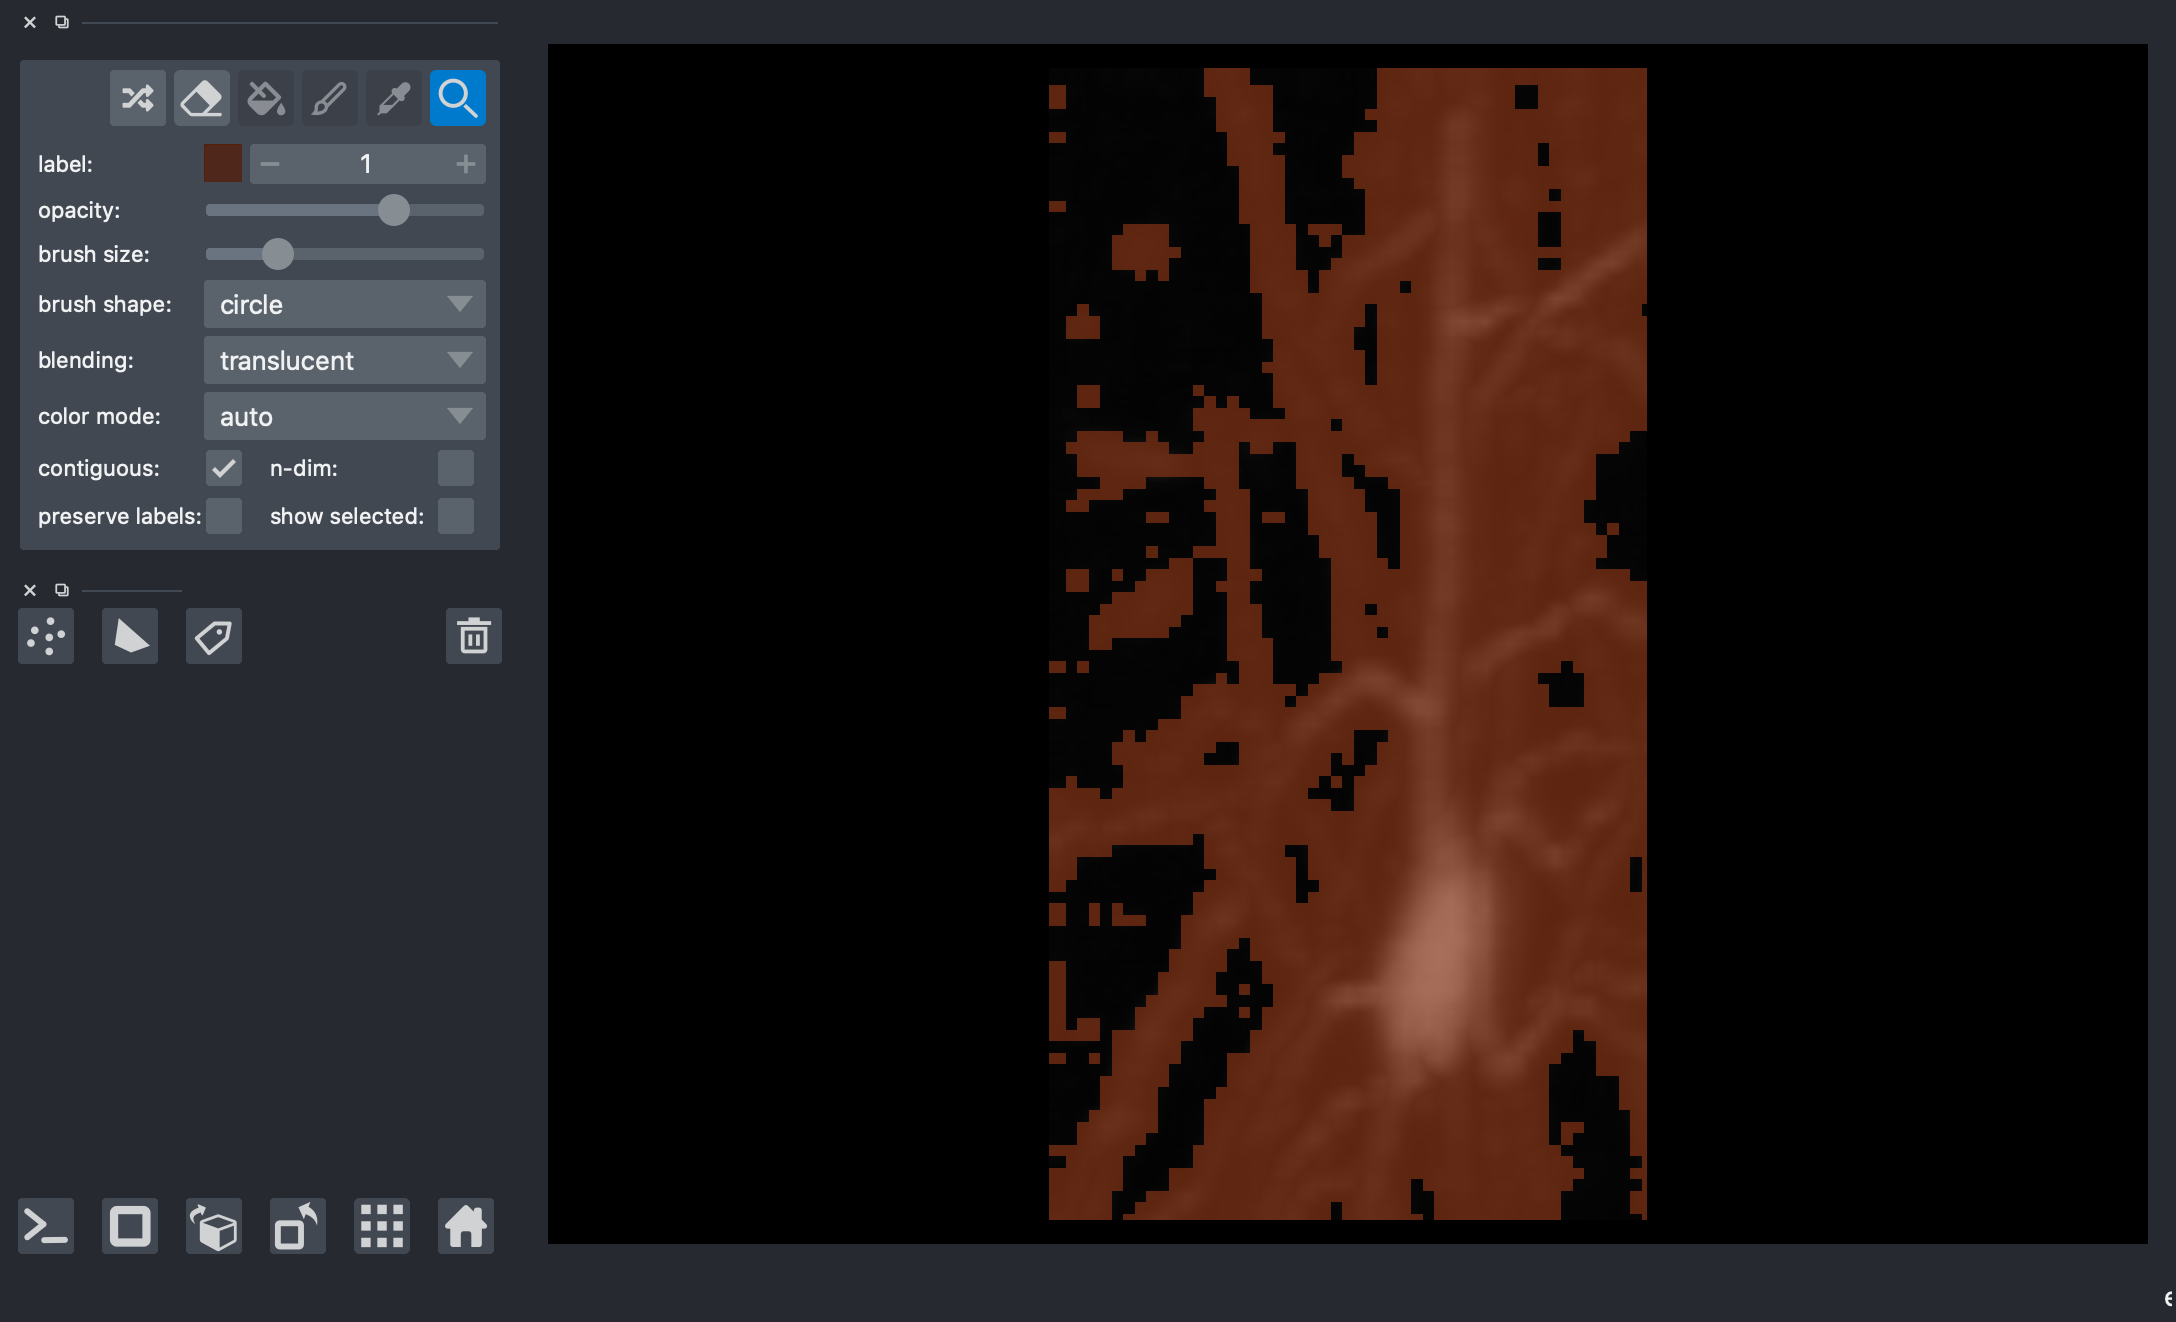

In [15]:
labels = adaptive_thresh.gmm_seg(img,numpy_seed)
label_img = sitk.GetImageFromArray(labels, isVector=False)
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(img)
viewer.add_labels(sitk.GetArrayFromImage(label_img))
nbscreenshot(viewer)

## Otsu's Method
Otsu's method thresholds the volume into two classes (segments) by maximizing inter-class variance.

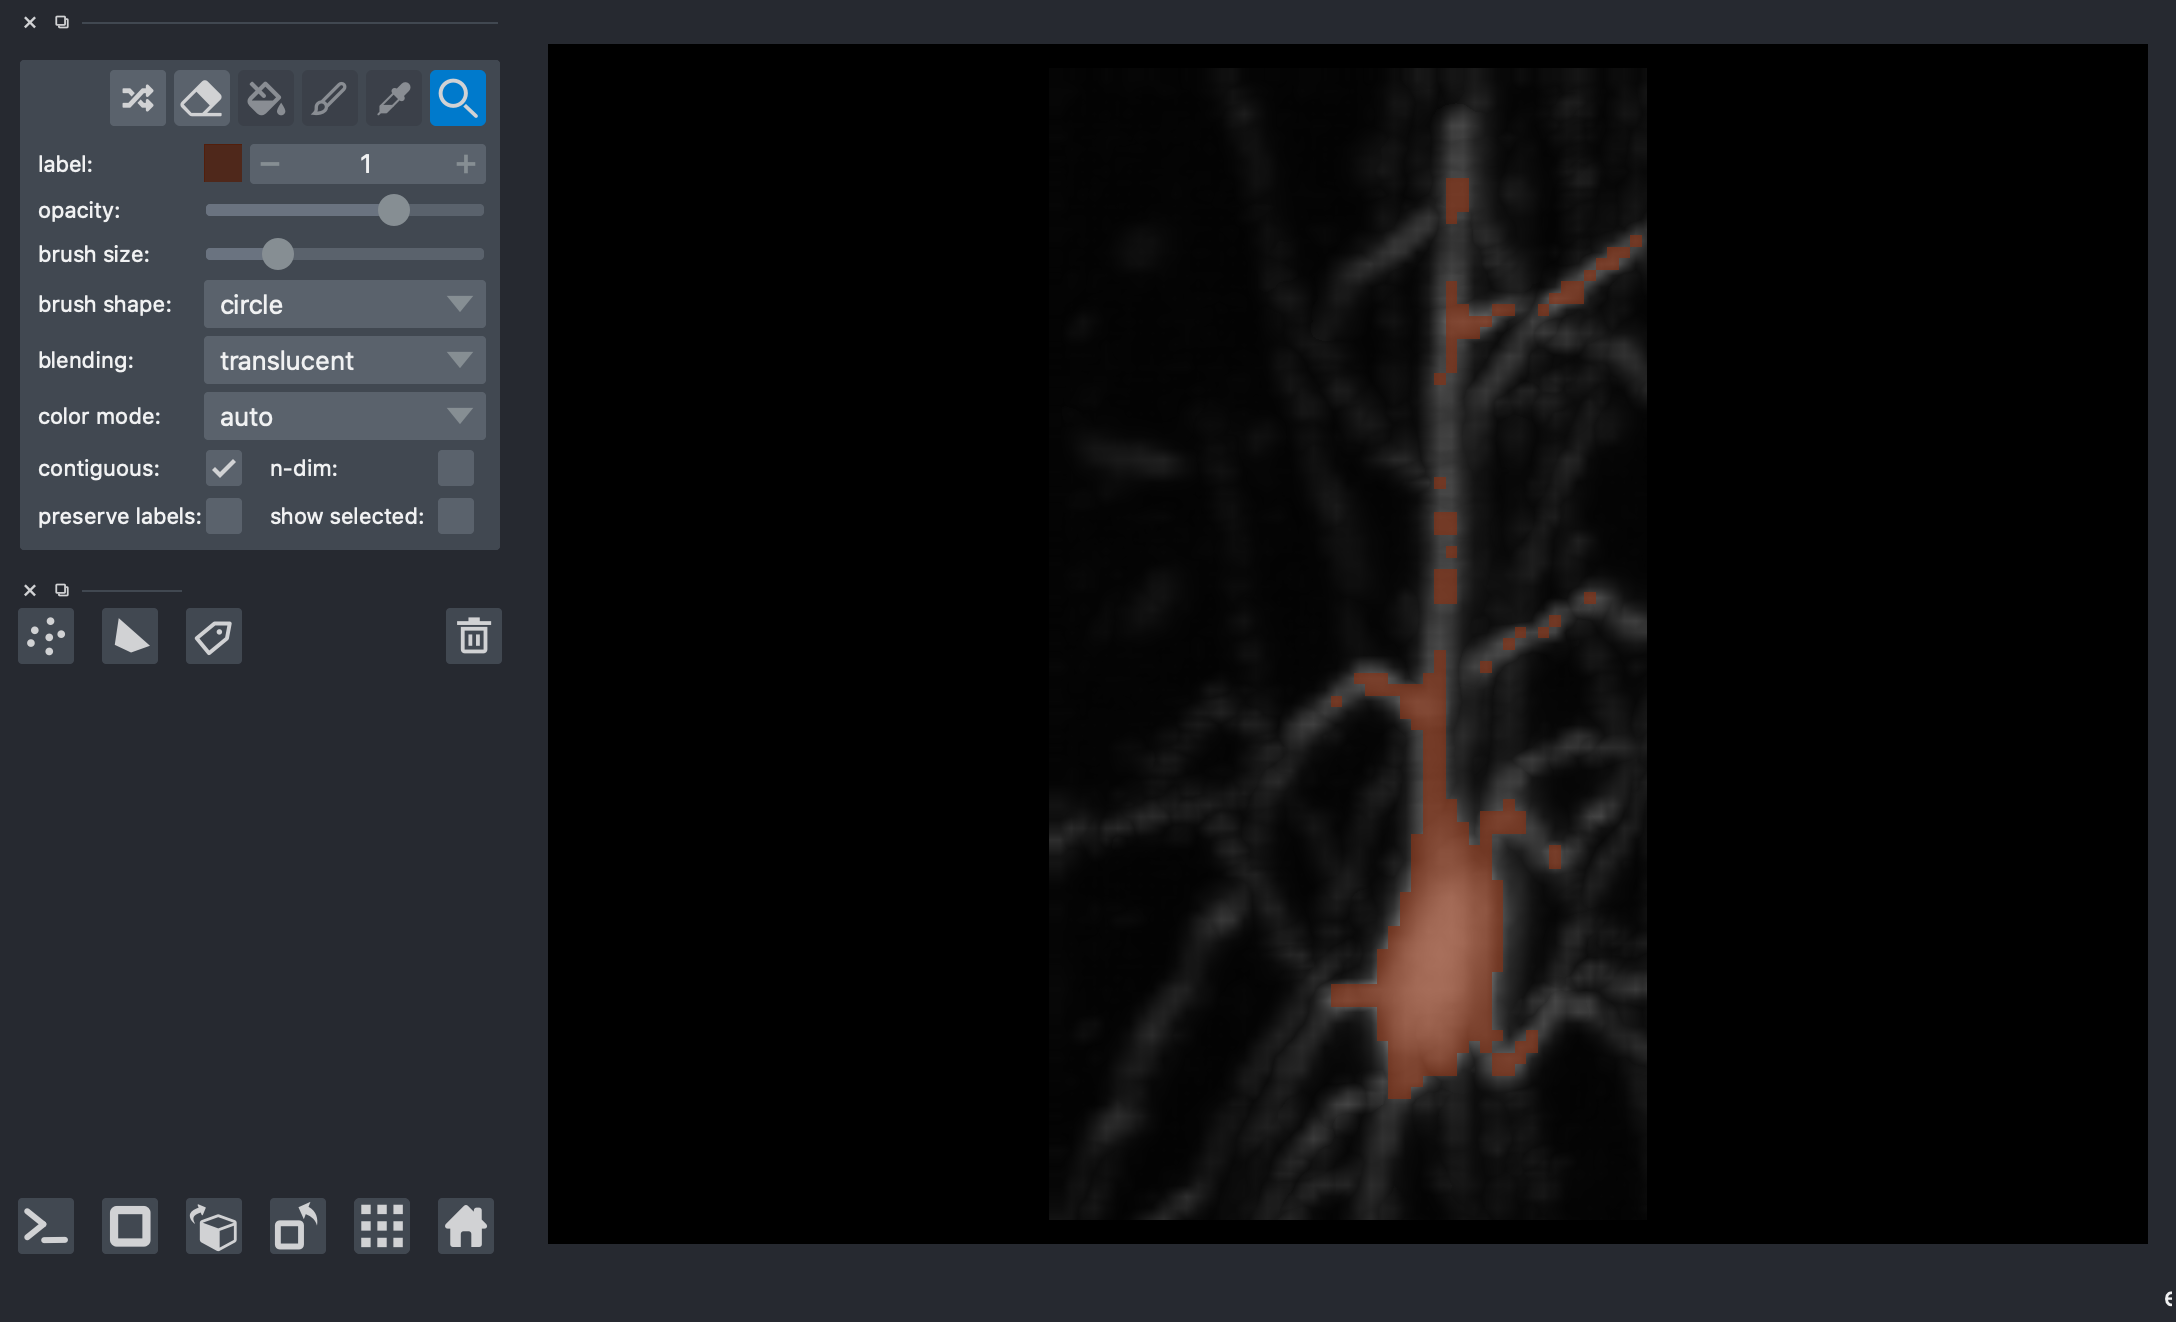

In [16]:
labels = adaptive_thresh.otsu(img,numpy_seed)
label_img = sitk.GetImageFromArray(labels, isVector=False)
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(img)
viewer.add_labels(sitk.GetArrayFromImage(label_img))
nbscreenshot(viewer)

## Region growing methods
Region growing methods iteratively examine pixels neighboring seed points, and determine if these neighboring pixels should be added to a region. Three such methods are available: \ In closed-connected thresholding, pixels in a region are connected to a seed and lie within a range of values. Here, the lower threshold is automatically calculated based on the Gaussian Mixture model thresholding above. \ In neighborhood-connected thrsholding, pixels in a region are connected to a seed and lie within a neighborhood. Again, the lower threshold is automatically calculated based on the Gaussian Mixture model thresholding above.\ In confidence-connected thresholding, pixels in a region have intensities consistent with a seed point; the pixel intensities lie within a confidence interval such that they are within some "multiplier" number of standard deviations from the mean of the neighborhood of the seed point. In this example, the multiplier is set to 1. If multiple iterations are used, the mean and standard deviation are calculated again at each iteration using pixels in the previous segmentation.

In each of these methods, binary morphological closing is used to connect separate segments of the neuron / fill holes after the algorithm has run.

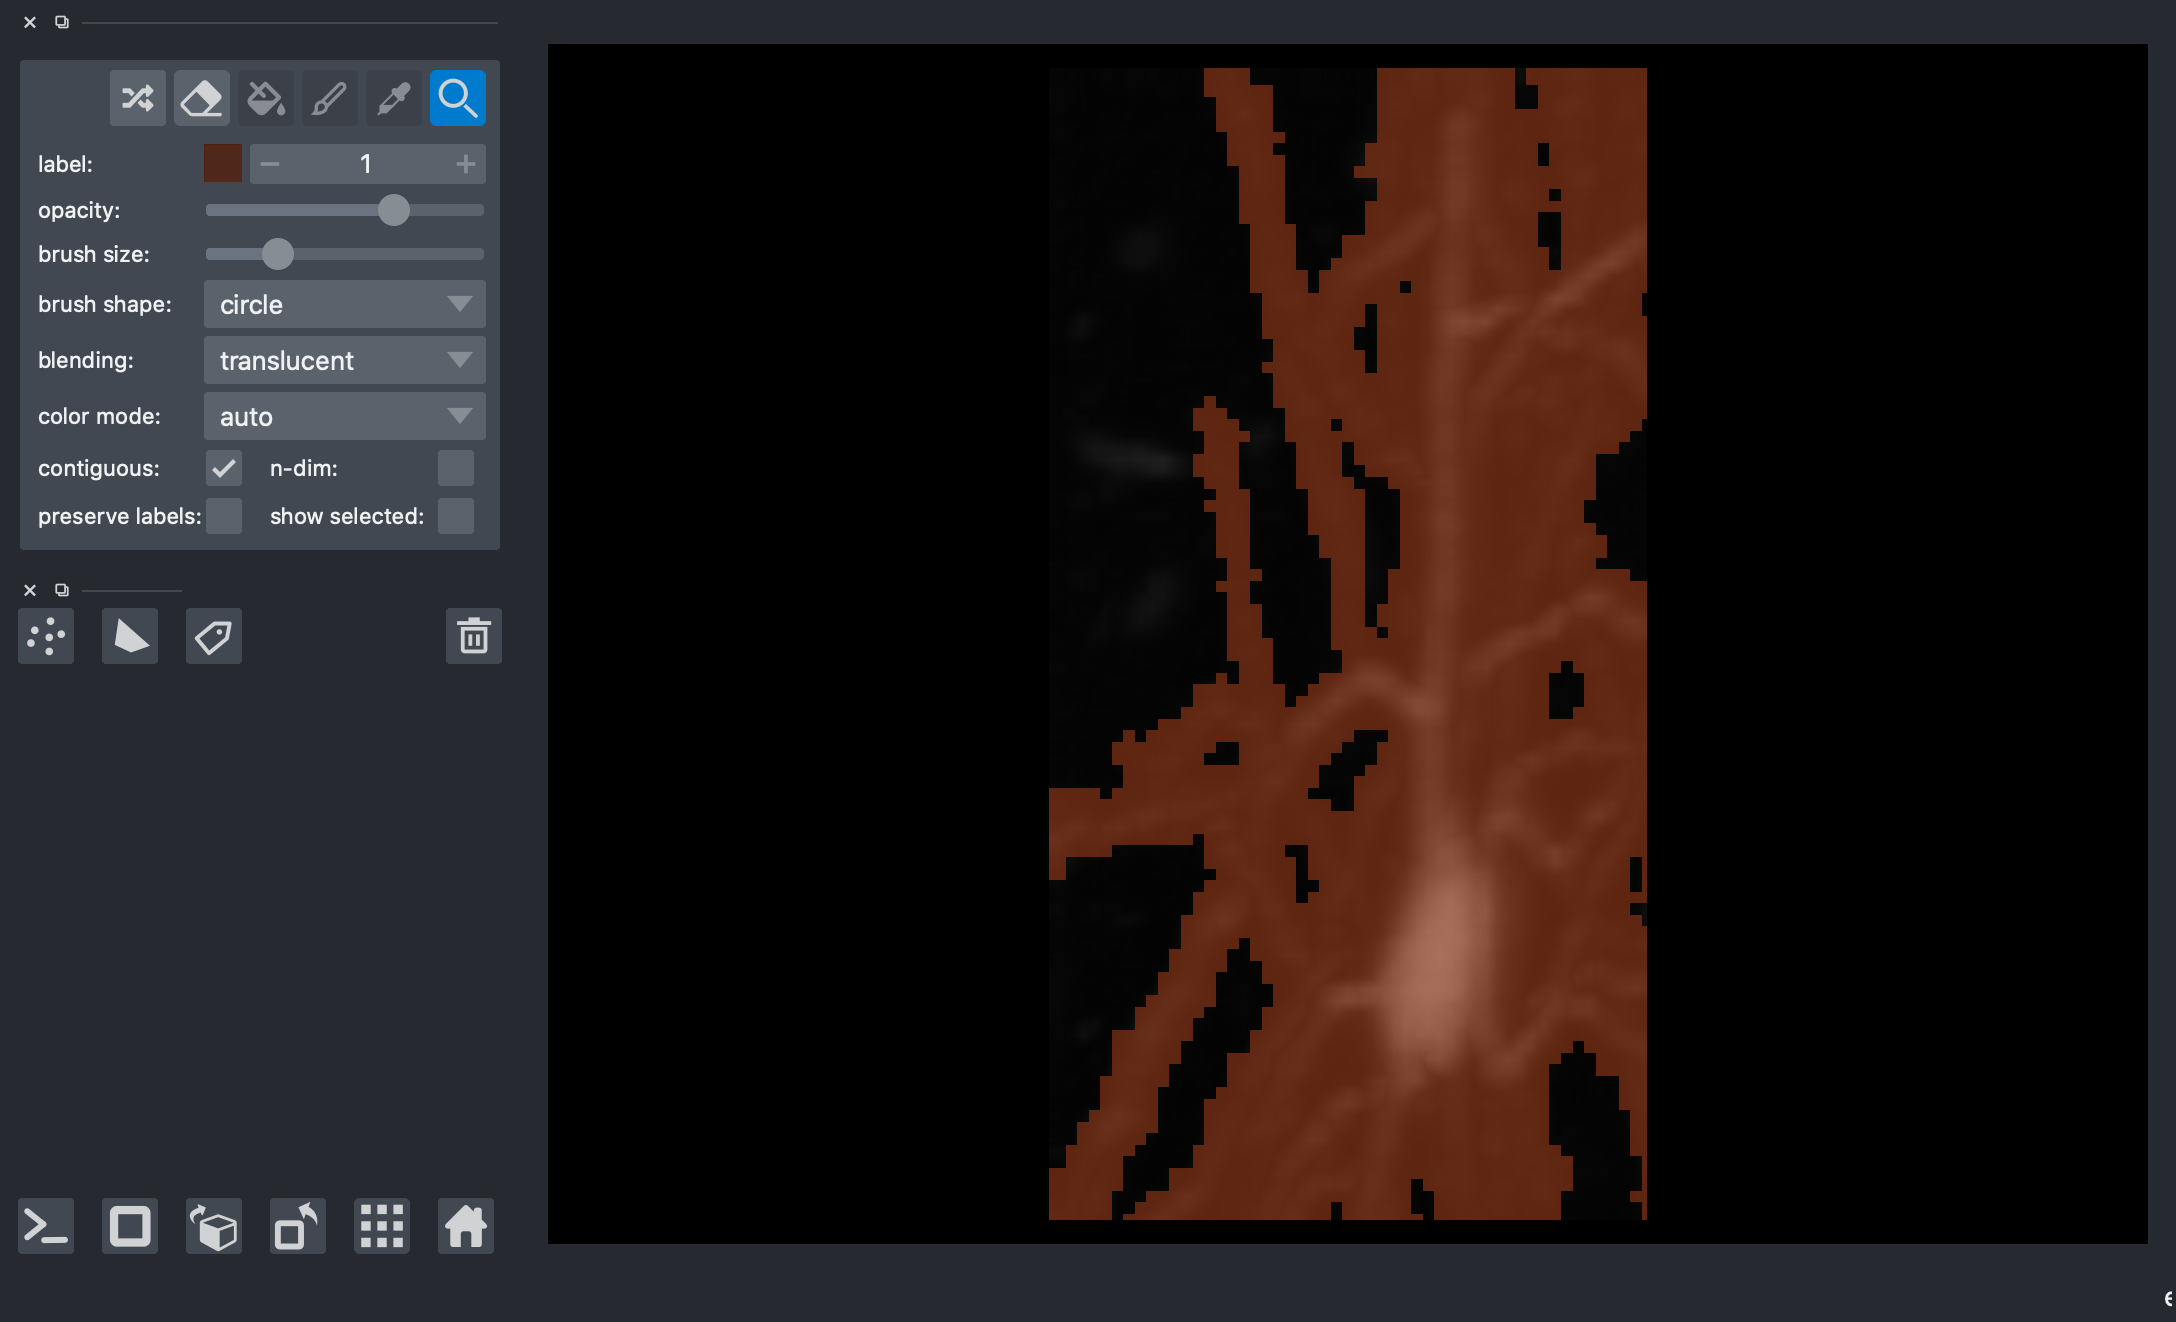

In [17]:
labels = adaptive_thresh.connected_threshold(img, [sitk_seed])
label_img = sitk.GetImageFromArray(labels, isVector=False)
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(img)
viewer.add_labels(sitk.GetArrayFromImage(label_img))
nbscreenshot(viewer)

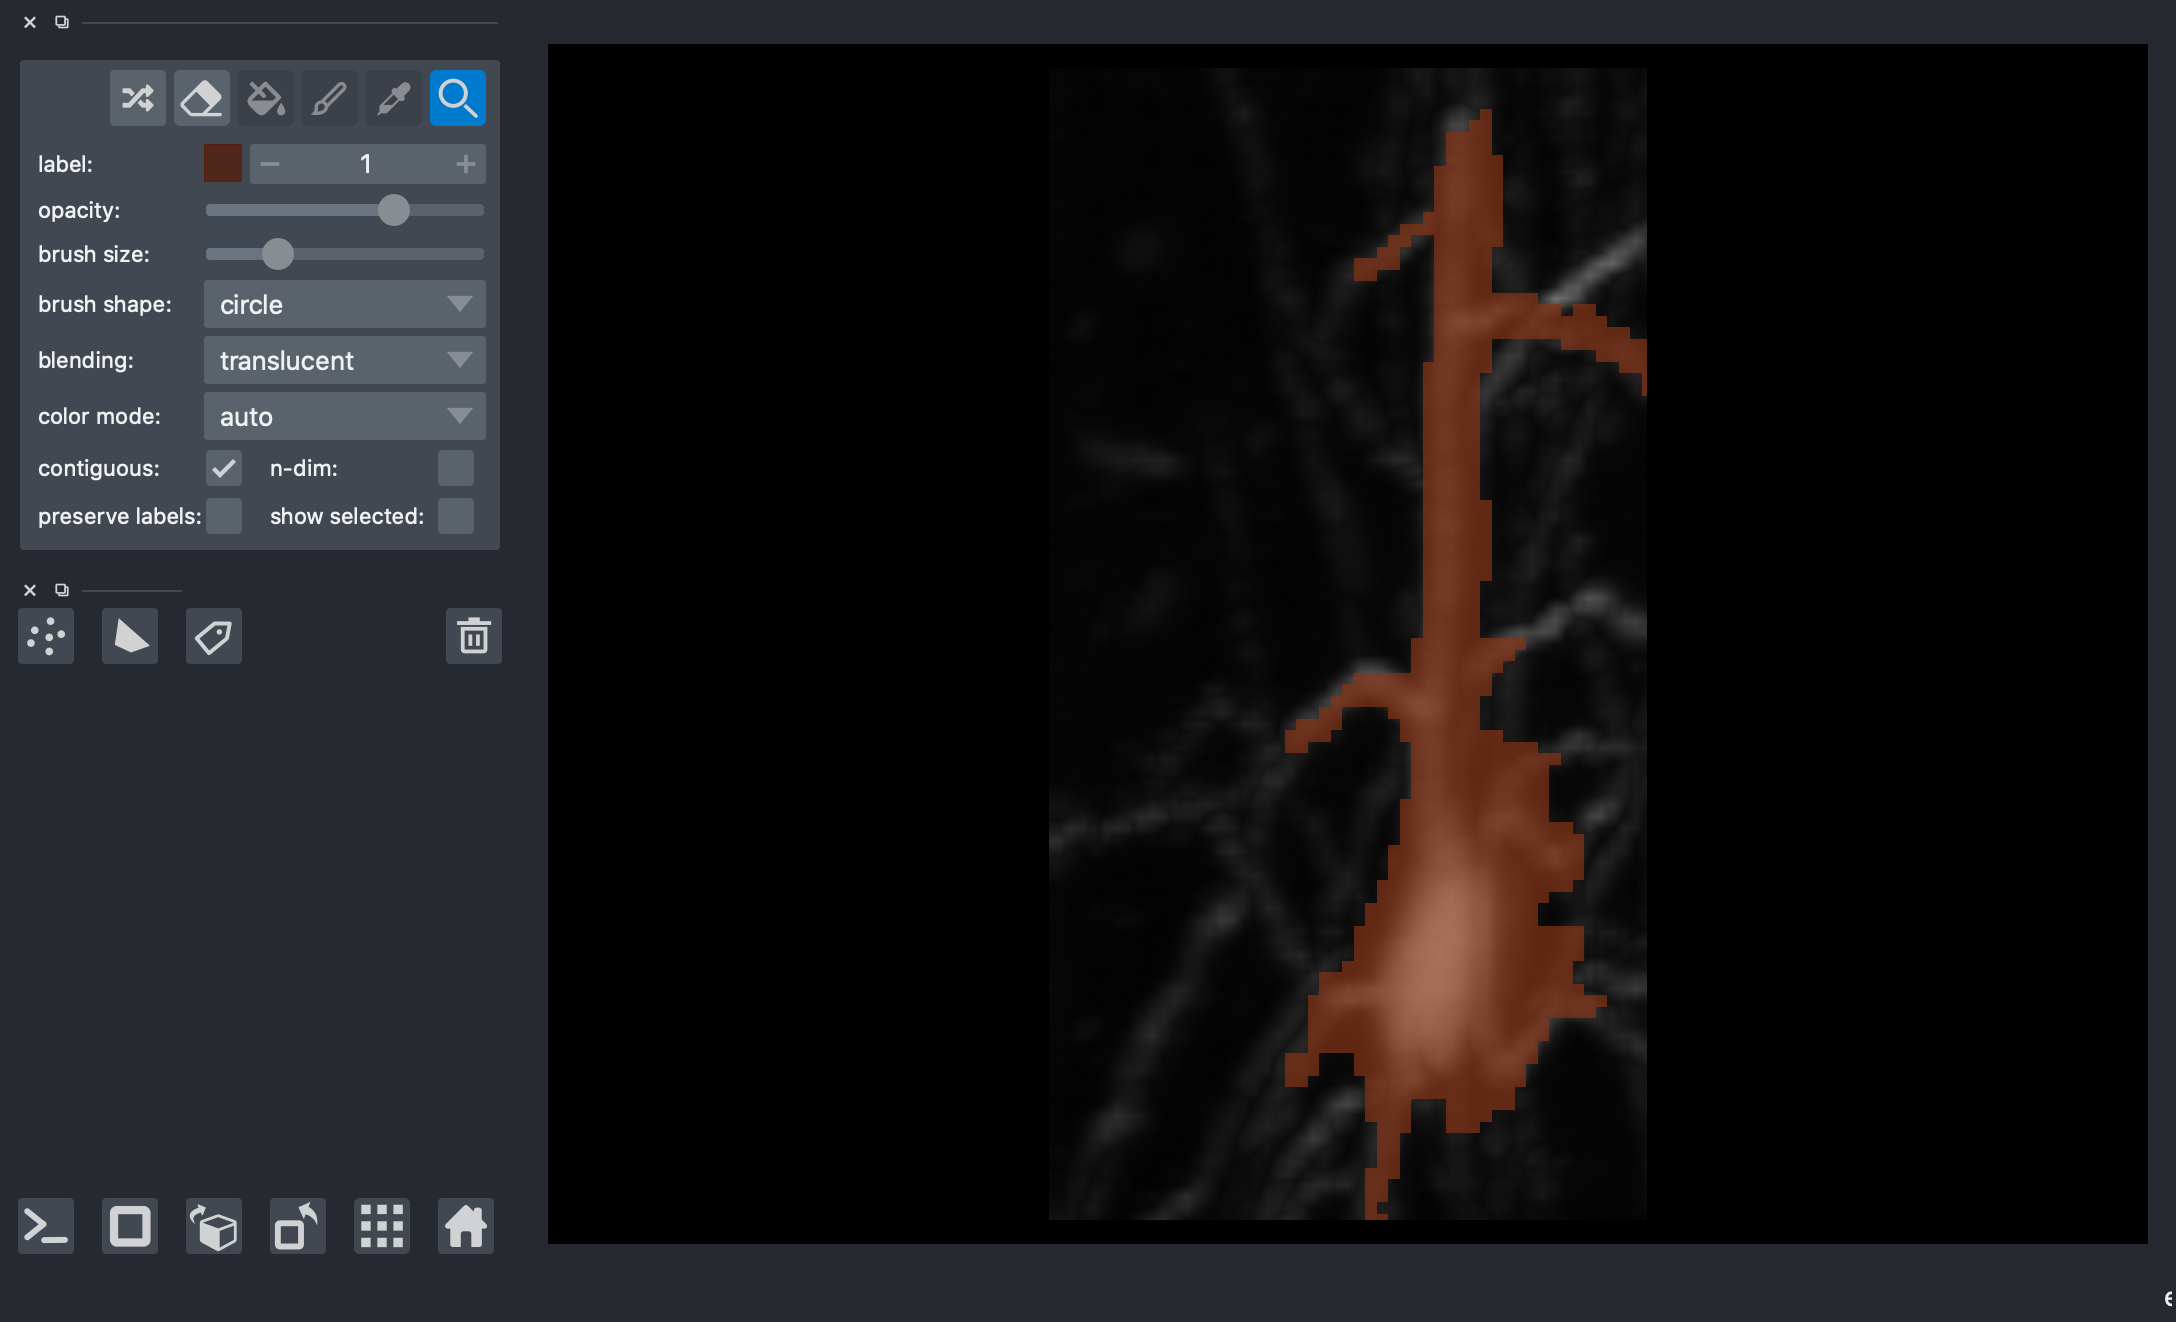

In [18]:
labels = adaptive_thresh.neighborhood_connected_threshold(img, [sitk_seed])
label_img = sitk.GetImageFromArray(labels, isVector=False)
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(img)
viewer.add_labels(sitk.GetArrayFromImage(label_img))
nbscreenshot(viewer)

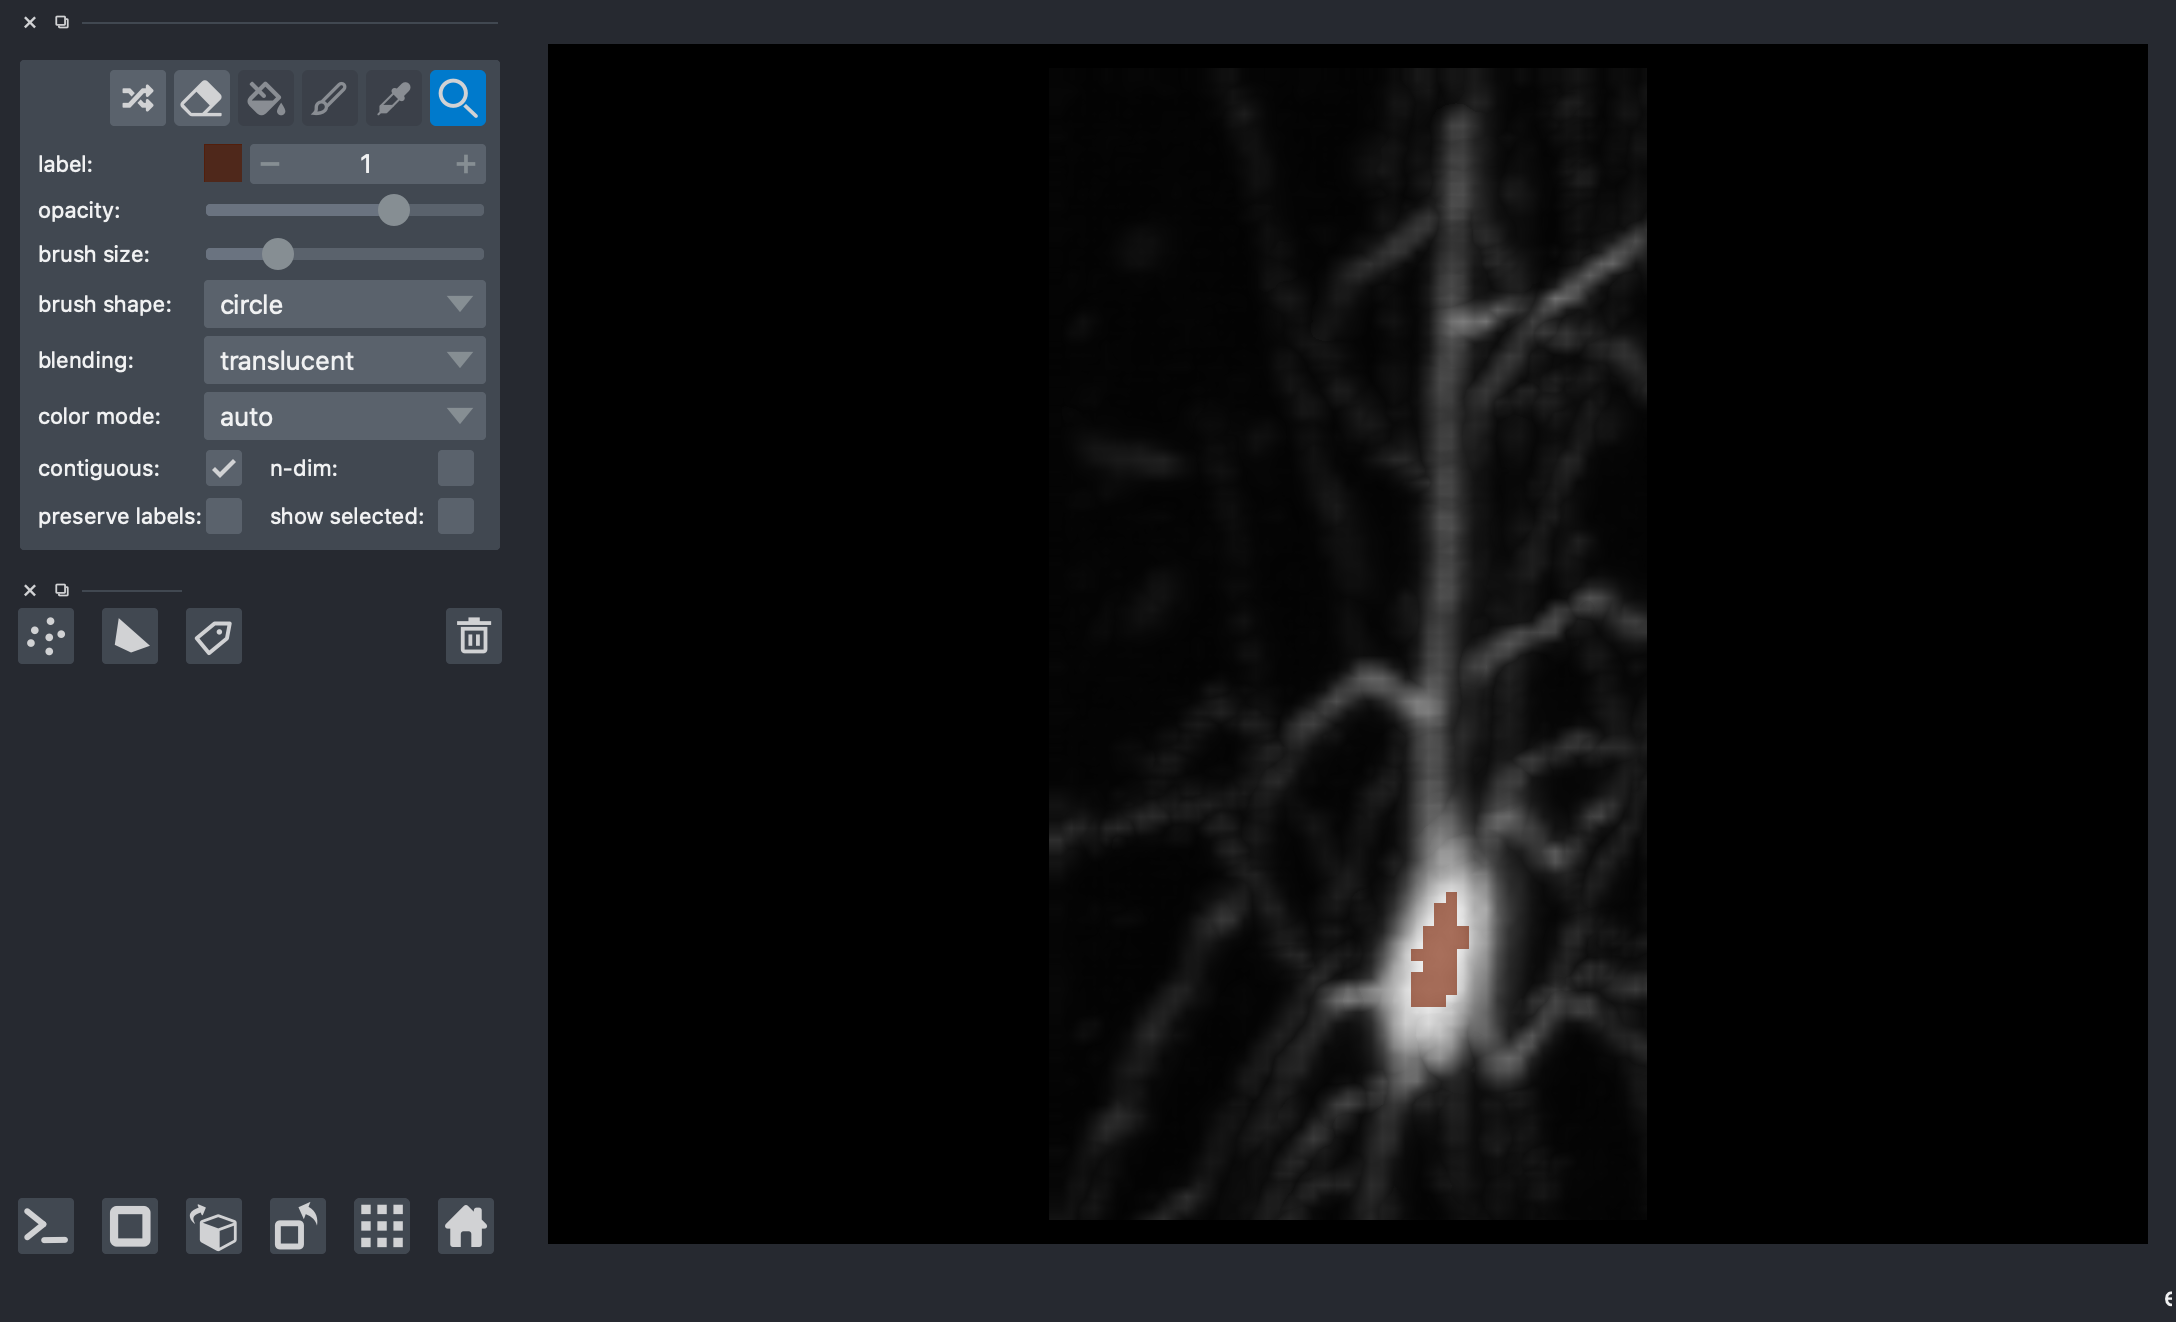

In [19]:
labels = adaptive_thresh.confidence_connected_threshold(img, [sitk_seed], num_iter=1, multiplier=1)
label_img = sitk.GetImageFromArray(labels, isVector=False)
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(img)
viewer.add_labels(sitk.GetArrayFromImage(label_img))
nbscreenshot(viewer)

Since this thresholding doesn't appear to segment the image, we'll try again with a larger multiplier, 5 times the value previously used.

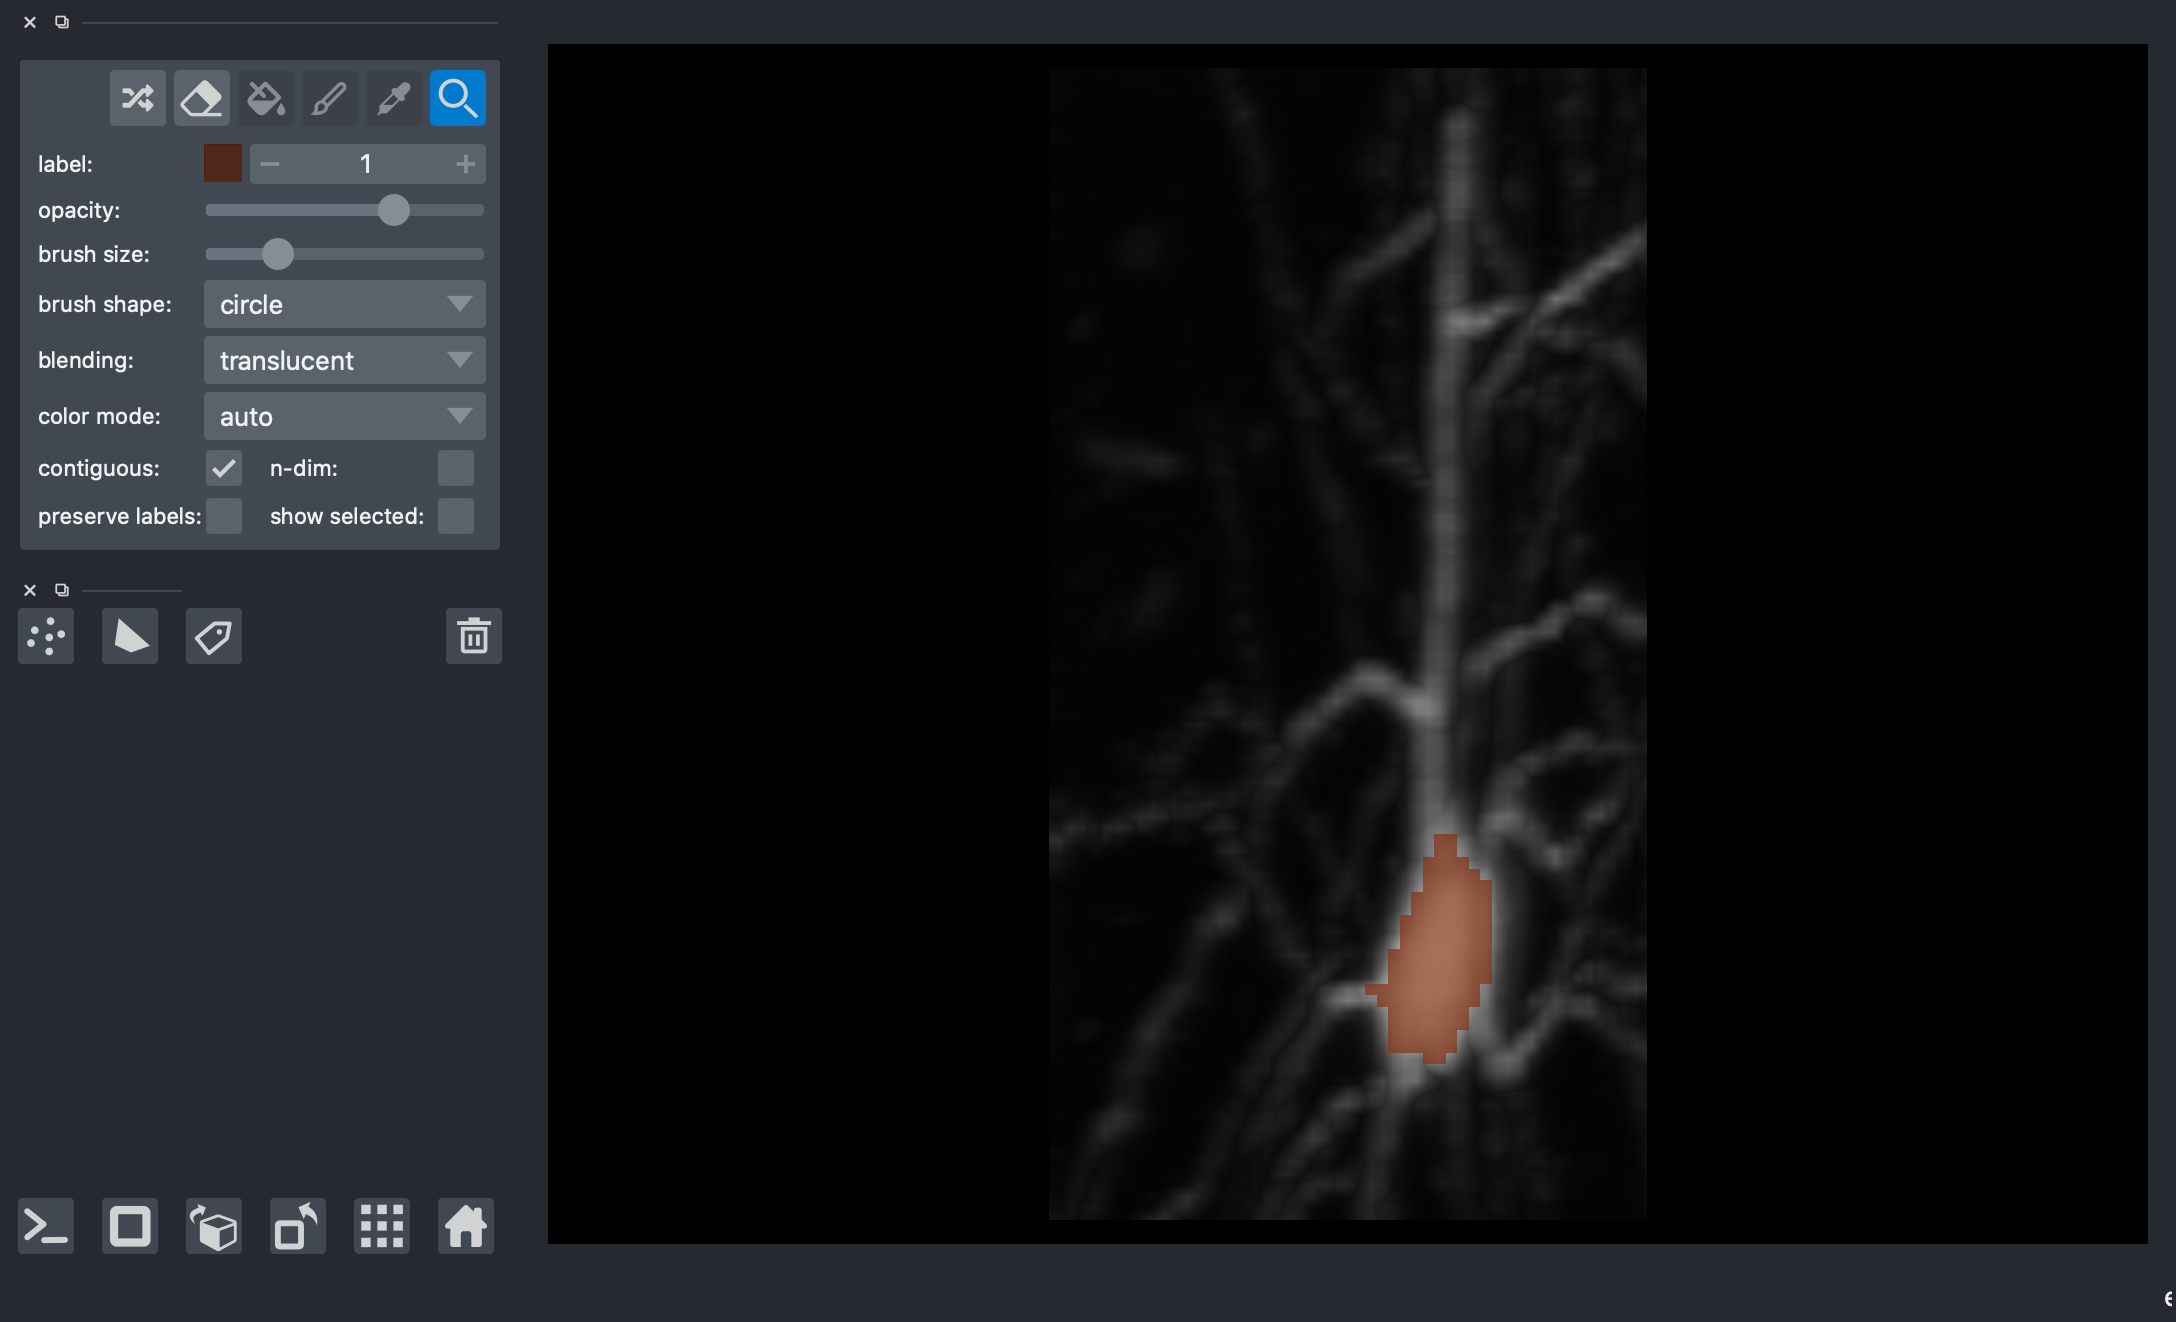

In [20]:
labels = adaptive_thresh.confidence_connected_threshold(img, [sitk_seed], num_iter=1, multiplier=5)
label_img = sitk.GetImageFromArray(labels, isVector=False)
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(img)
viewer.add_labels(sitk.GetArrayFromImage(label_img))
nbscreenshot(viewer)

## Level-set segmentation
The level set method segments an image based on its contours. The main idea is to begin with a region based on an initial contour, and expand the region outward until edges are reached. When root mean squared change in the level set function for an iteration is below a threshold, or the maximum number of iteration have elapsed, the algorithm is said to have converged. Lower and upper thresholds may be set to the mean of the image minus or plus its standard deviation times some factor (15 here), if the thresholds are not set explicitly.

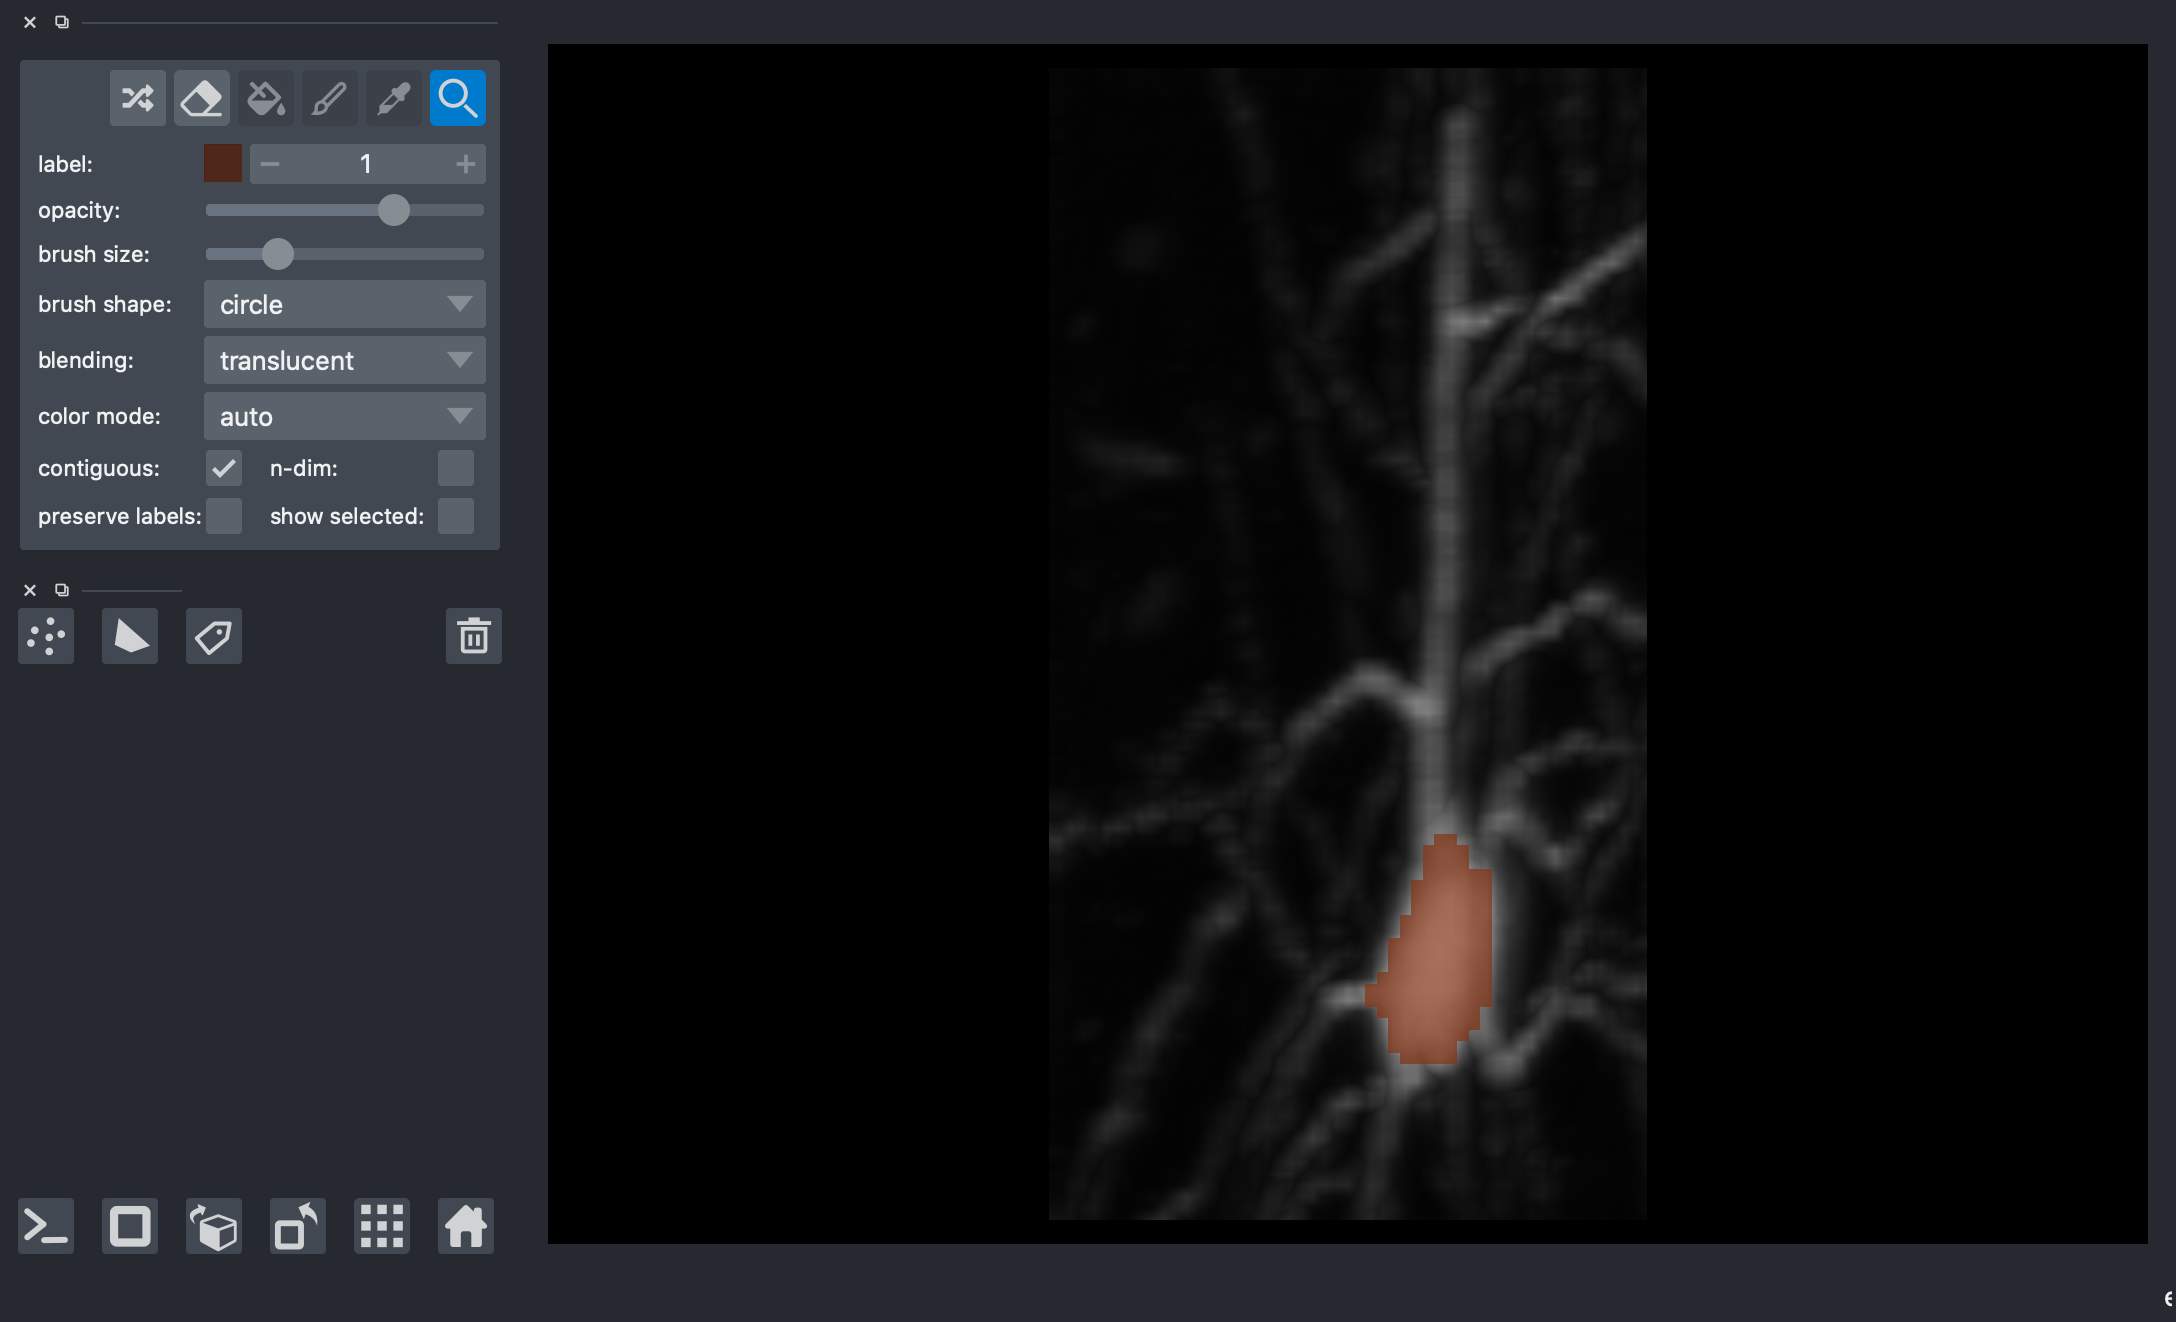

In [21]:
labels = adaptive_thresh.level_set_seg(img, sitk_seed, factor = 15)
label_img = sitk.GetImageFromArray(labels, isVector=False)
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(img)
viewer.add_labels(sitk.GetArrayFromImage(label_img))
nbscreenshot(viewer)

## Fast-marching segmentation
The fast marching method is another form of level-set segmentation. Only a positive speed term is used to govern the differential equation in the method.

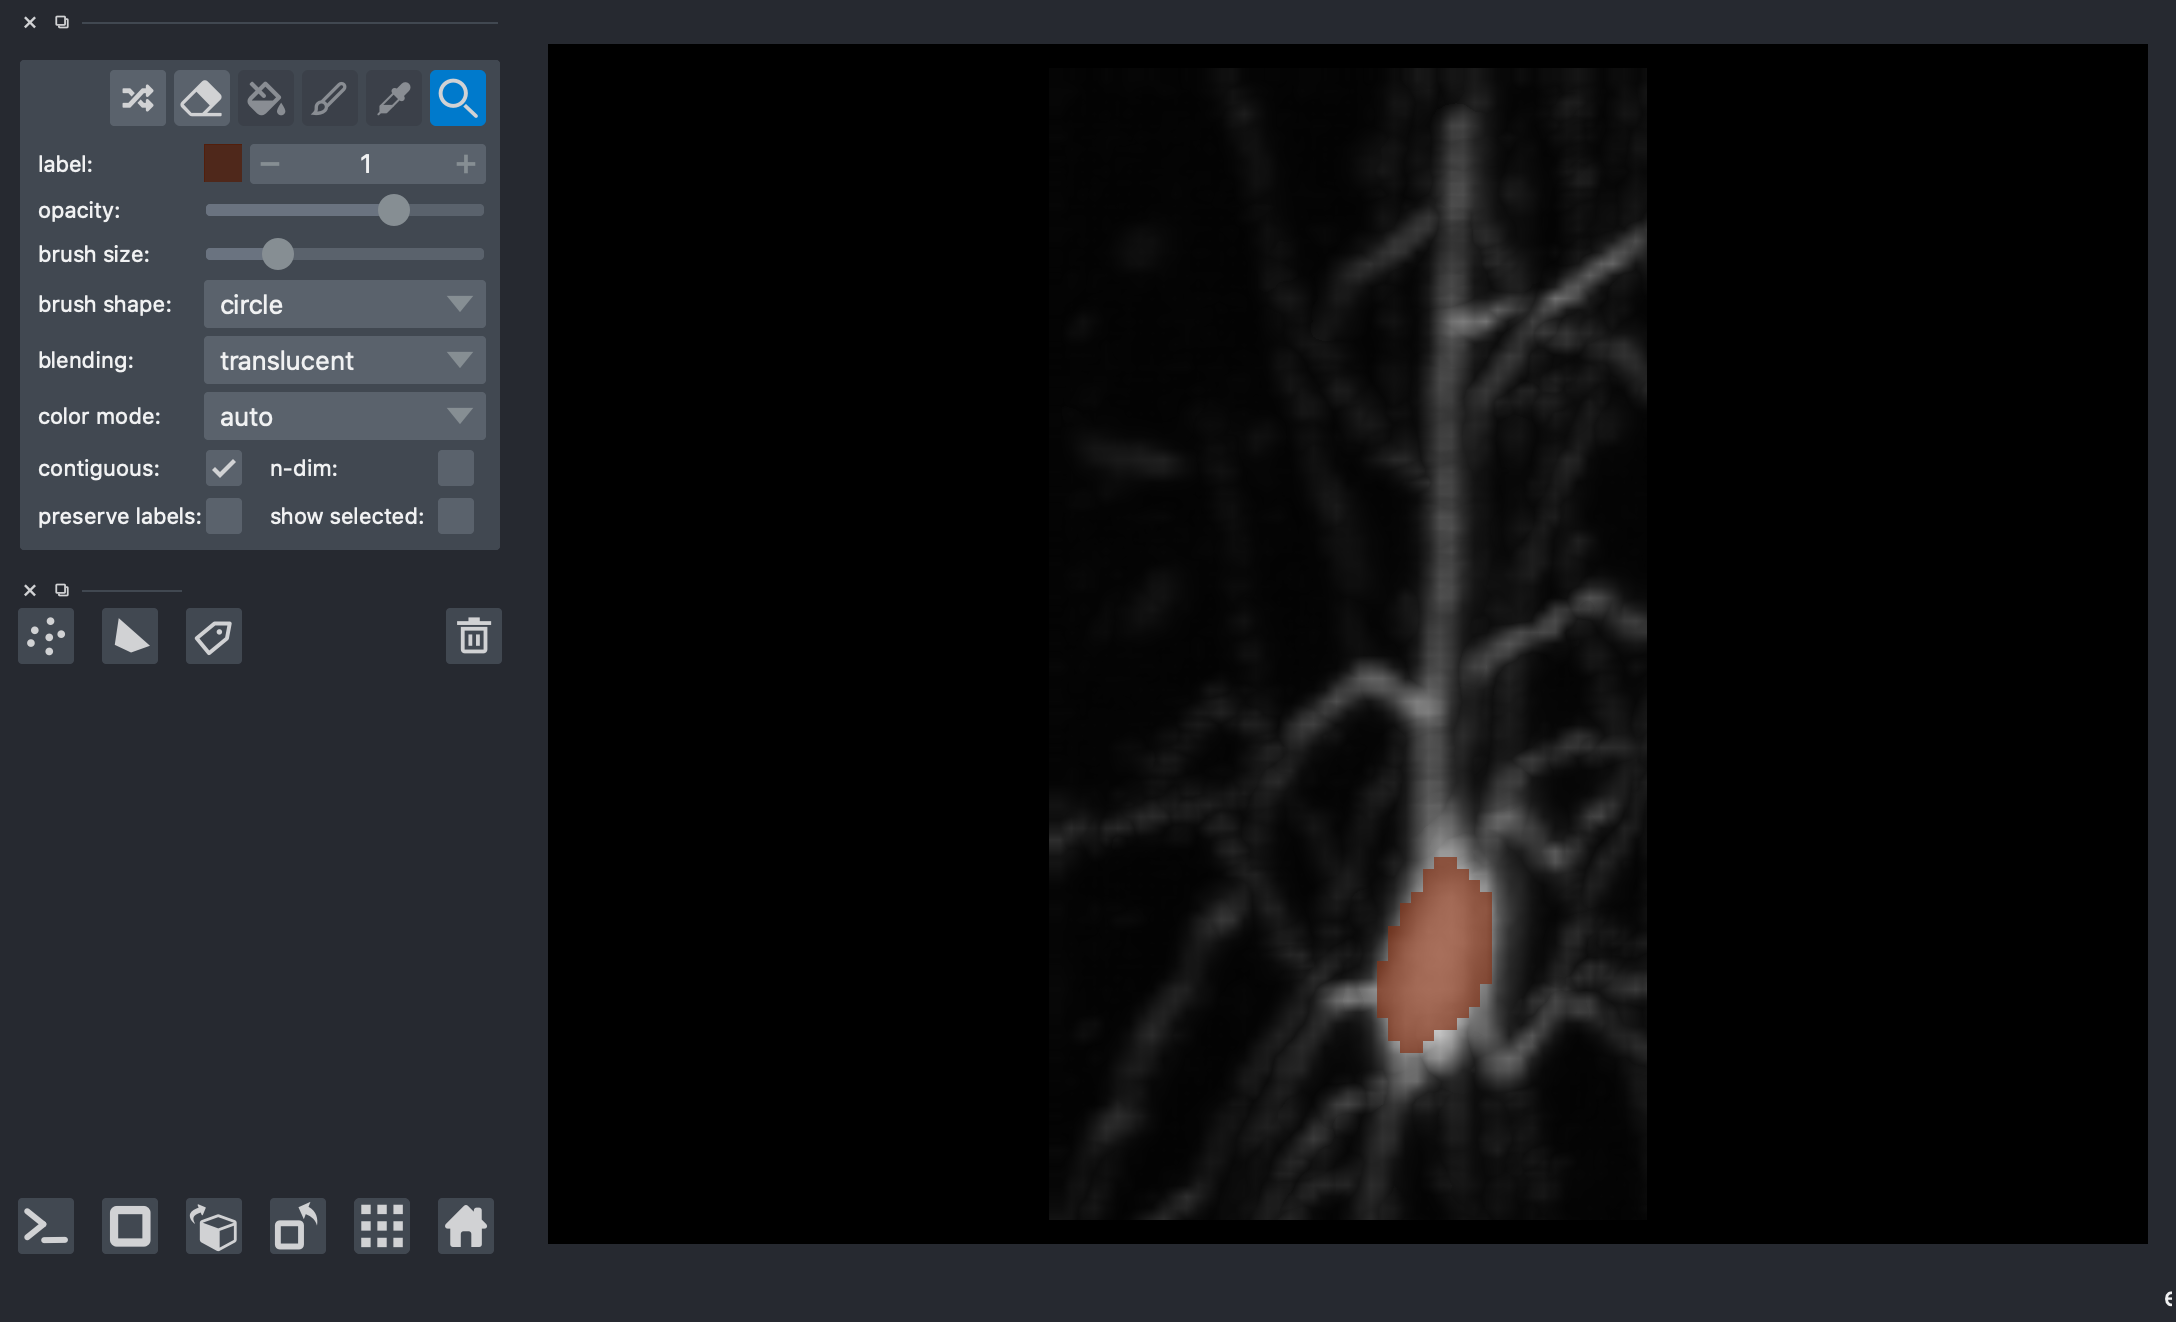

In [22]:
labels = adaptive_thresh.fast_marching_seg(img, sitk_seed)
label_img = sitk.GetImageFromArray(labels, isVector=False)
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(img)
viewer.add_labels(sitk.GetArrayFromImage(label_img))
nbscreenshot(viewer)

## Napari to view segmentations
We can also view the segmentations in 3D using Napari.

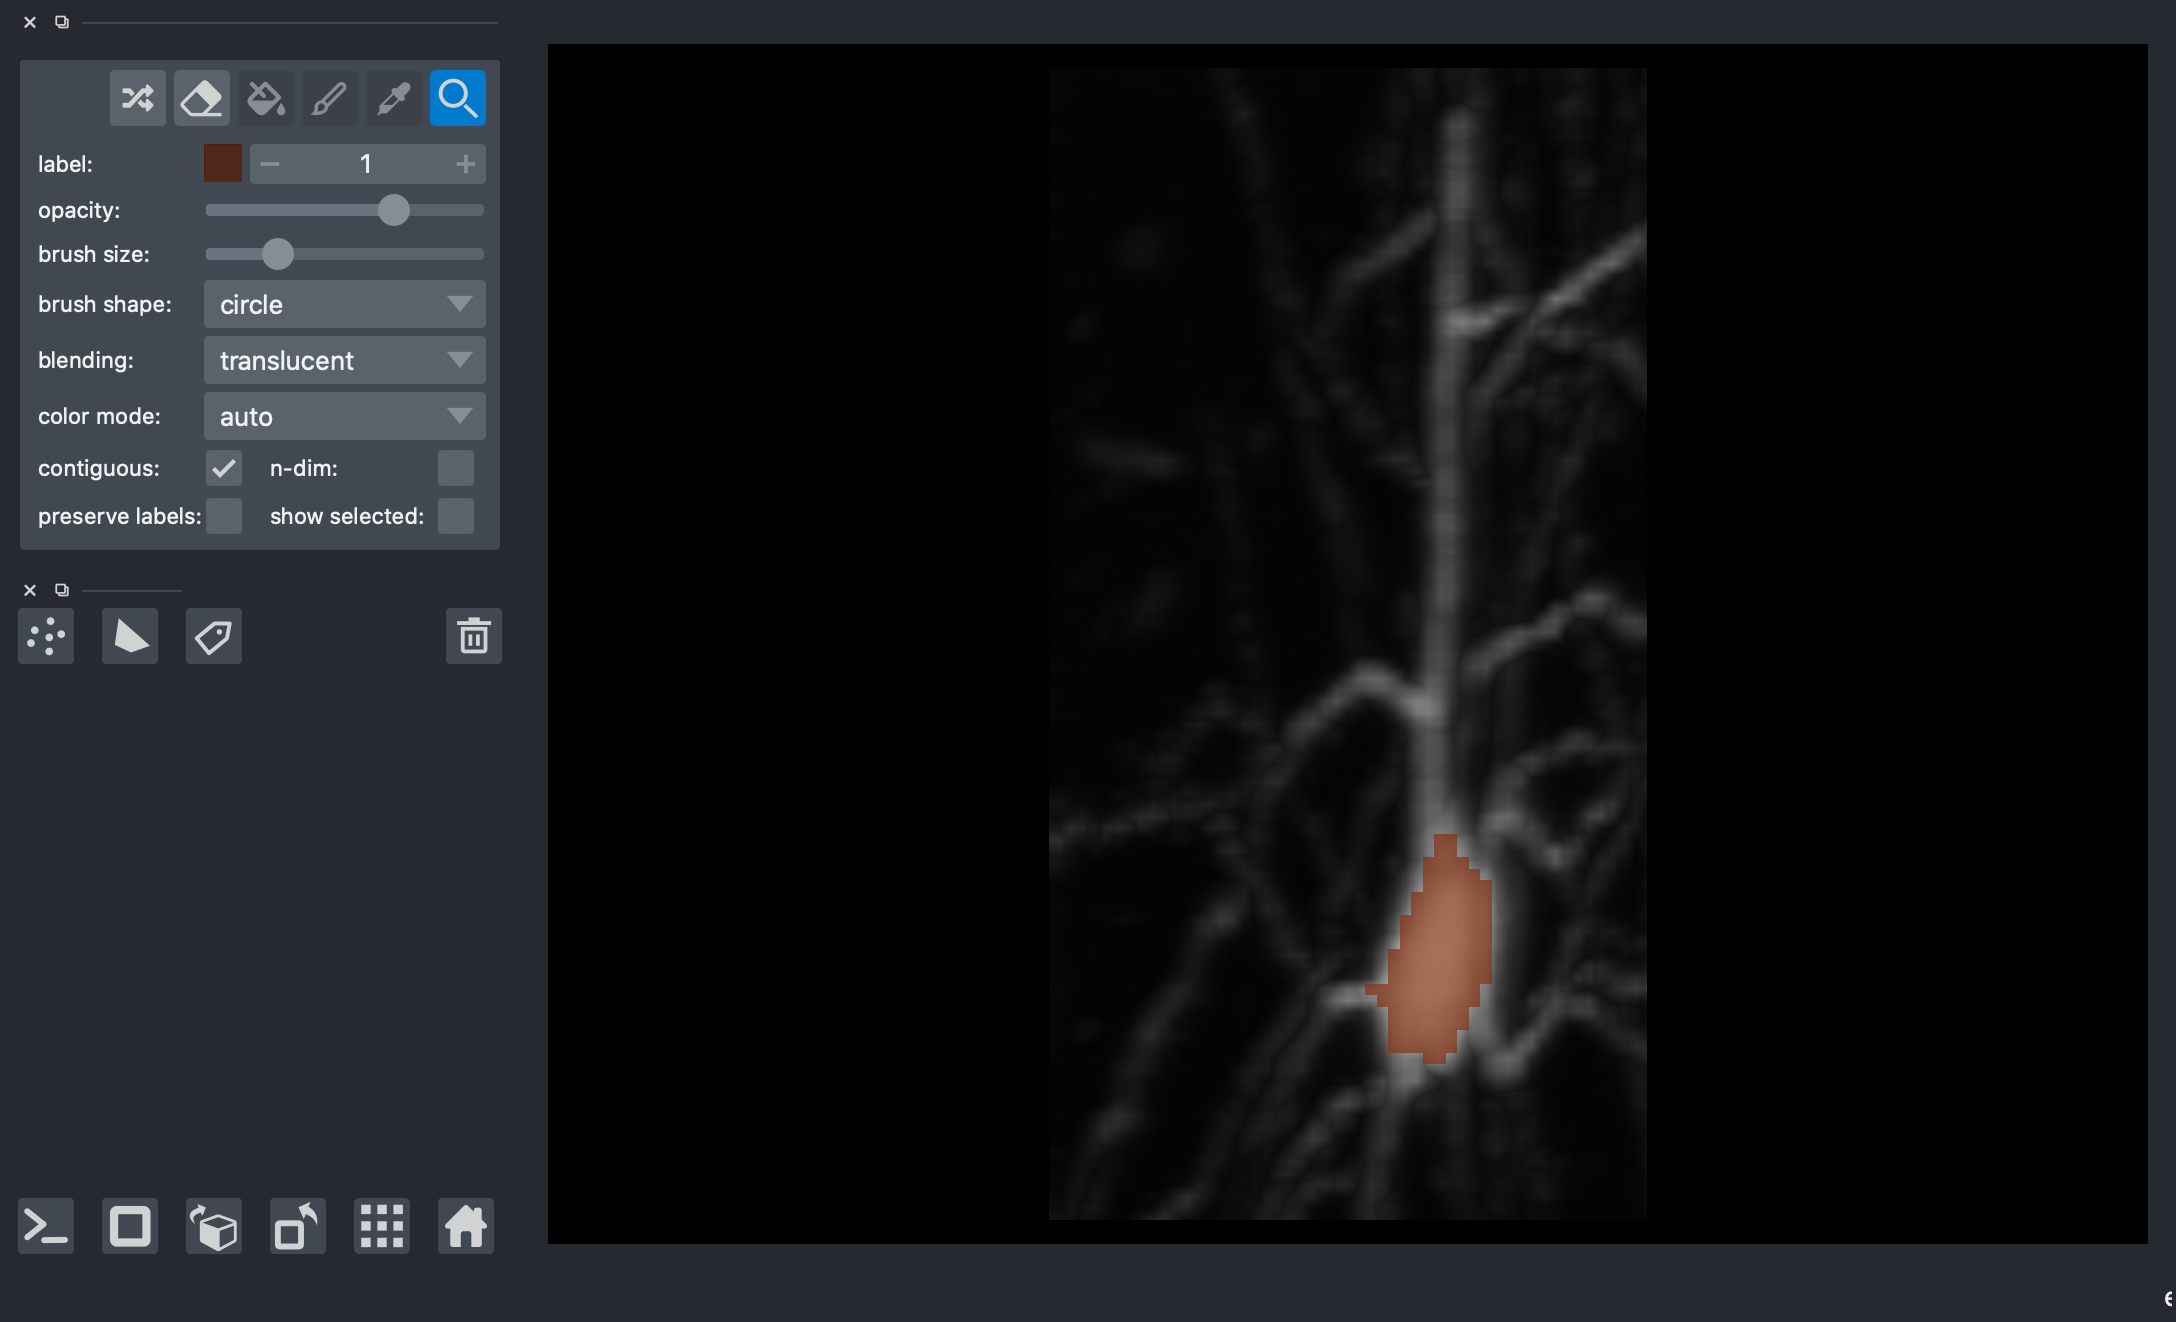

In [23]:
%gui qt
labels = adaptive_thresh.confidence_connected_threshold(img, [sitk_seed], num_iter=1, multiplier=5)
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(img)
viewer.add_labels(labels)
nbscreenshot(viewer)